# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from itertools import product

Load feature names.

In [2]:
feature_names = []
with open('./data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)
print feature_names

Loaded feature names: 126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-colo

Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('./data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():
# References:
#   - PCA.ipnyb

    # run PCA using all of the features
    n_comp = len(feature_names)
    pca_all = PCA(n_components = n_comp)
    pca_all.fit(train_data)

    # check outcome attributes
    print 'Number of components: \n', pca_all.n_components_
    print 'Explained variance: \n', pca_all.explained_variance_
    print 'Explained variance ratio: \n', pca_all.explained_variance_ratio_ 
    print 'Cumulative explained variance: \n', np.cumsum(pca_all.explained_variance_ratio_)
    #SANITY CHECK: print np.sum(pca_all.explained_variance_ratio_)
    print 'Mean: \n', pca_all.mean_
    print 'PCA components: \n', pca_all.components_ 
  
    # output variance fractions
    print '\n-------------------------------------------'
    print 'Fraction of the total variance in the training explained by first k components: \n'
    for k in range(1,51):
        s = sum(pca_all.explained_variance_ratio_[0:k]) 
        #SANITY CHECK: print np.cumsum(pca_all.explained_variance_ratio_)[k-1]
        print("%d \t %s \t %s" % (k, '{0:.2f}%'.format(s * 100), feature_names[k]))
    
P1()

Number of components: 
126
Explained variance: 
[  1.86480691e+00   1.51458265e+00   1.15649530e+00   8.02946226e-01
   4.39551525e-01   4.18425426e-01   3.55611076e-01   3.10765018e-01
   2.97436660e-01   2.53608455e-01   2.32831623e-01   2.12387562e-01
   1.97165135e-01   1.91474271e-01   1.72655851e-01   1.71496297e-01
   1.62460632e-01   1.60514371e-01   1.50628059e-01   1.30317741e-01
   1.21756319e-01   1.21151644e-01   1.18334771e-01   1.12961379e-01
   1.03227308e-01   9.88230202e-02   9.04438932e-02   8.81939630e-02
   8.38452360e-02   7.96057719e-02   7.28939200e-02   6.98564834e-02
   6.50628720e-02   6.06617153e-02   5.97872132e-02   5.71428571e-02
   5.67299343e-02   5.18304470e-02   5.14714334e-02   4.99940699e-02
   4.76865509e-02   4.52098715e-02   4.20655881e-02   4.08703707e-02
   3.84371586e-02   3.39881336e-02   3.09238756e-02   2.67945147e-02
   2.51681720e-02   2.32416325e-02   2.12324901e-02   2.03479298e-02
   1.62423022e-02   1.39391155e-02   1.28003106e-02   1

NOTES/OBSERVATIONS/REFLECTIONS:

The first 50 features explained most of the variance. I wonder what the least number of components would account for the most variance.


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Plotting: color - red, y-value - 0, label - non-poisonous
Plotting: color - blue, y-value - 1, label - poisonous


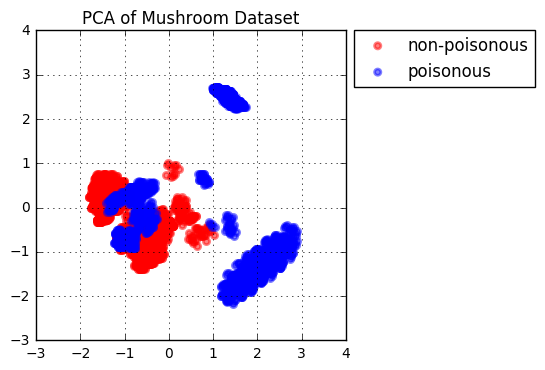

In [5]:
def P2():
# References:
#   - PCA.ipnyb
#   - http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

    # run PCA with two dimmensions
    n_comp = 2
    pca_two = PCA(n_components = n_comp)
    X = pca_two.fit(train_data).transform(train_data)
    y = train_labels 

    plt.figure()
    colors = ['red', 'blue']
    label_names = ['non-poisonous', 'poisonous']
    lw = 2

    for color, i, label_name in zip(colors, [0, 1], label_names):
        print("Plotting: color - %s, y-value - %d, label - %s" % (color, i, label_name))
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.5, lw=lw, label=label_name)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.91), shadow=False, scatterpoints=1)
    plt.title('PCA of Mushroom Dataset')   
    plt.grid(True)
    plt.axes().set_aspect('equal')
    
    plt.show()
    
P2()

NOTES/OBSERVATIONS/REFLECTIONS:

Loving pyplot more everytime I use it. Got to play with more Python features and gained understanding.

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

num clusters = 1, cluster num = 0, center = [  8.02564364e-16  -6.12684506e-17], population = 7000
num clusters = 2, cluster num = 0, center = [-0.96600017 -0.18214489], population = 4440
num clusters = 2, cluster num = 1, center = [ 1.67643875  0.31610217], population = 2560
num clusters = 3, cluster num = 0, center = [-0.95036104 -0.18013088], population = 4487
num clusters = 3, cluster num = 1, center = [ 1.9891398  -1.29271053], population = 1433
num clusters = 3, cluster num = 2, center = [ 1.30910432  2.46361246], population = 1080
num clusters = 4, cluster num = 0, center = [ 2.01310033 -1.3064972 ], population = 1406
num clusters = 4, cluster num = 1, center = [-1.31029696  0.20185745], population = 2537
num clusters = 4, cluster num = 2, center = [ 1.31621399  2.48904188], population = 1065
num clusters = 4, cluster num = 3, center = [-0.45494622 -0.666538  ], population = 1992
num clusters = 5, cluster num = 0, center = [-1.33596425  0.19535086], population = 2467
num cluster

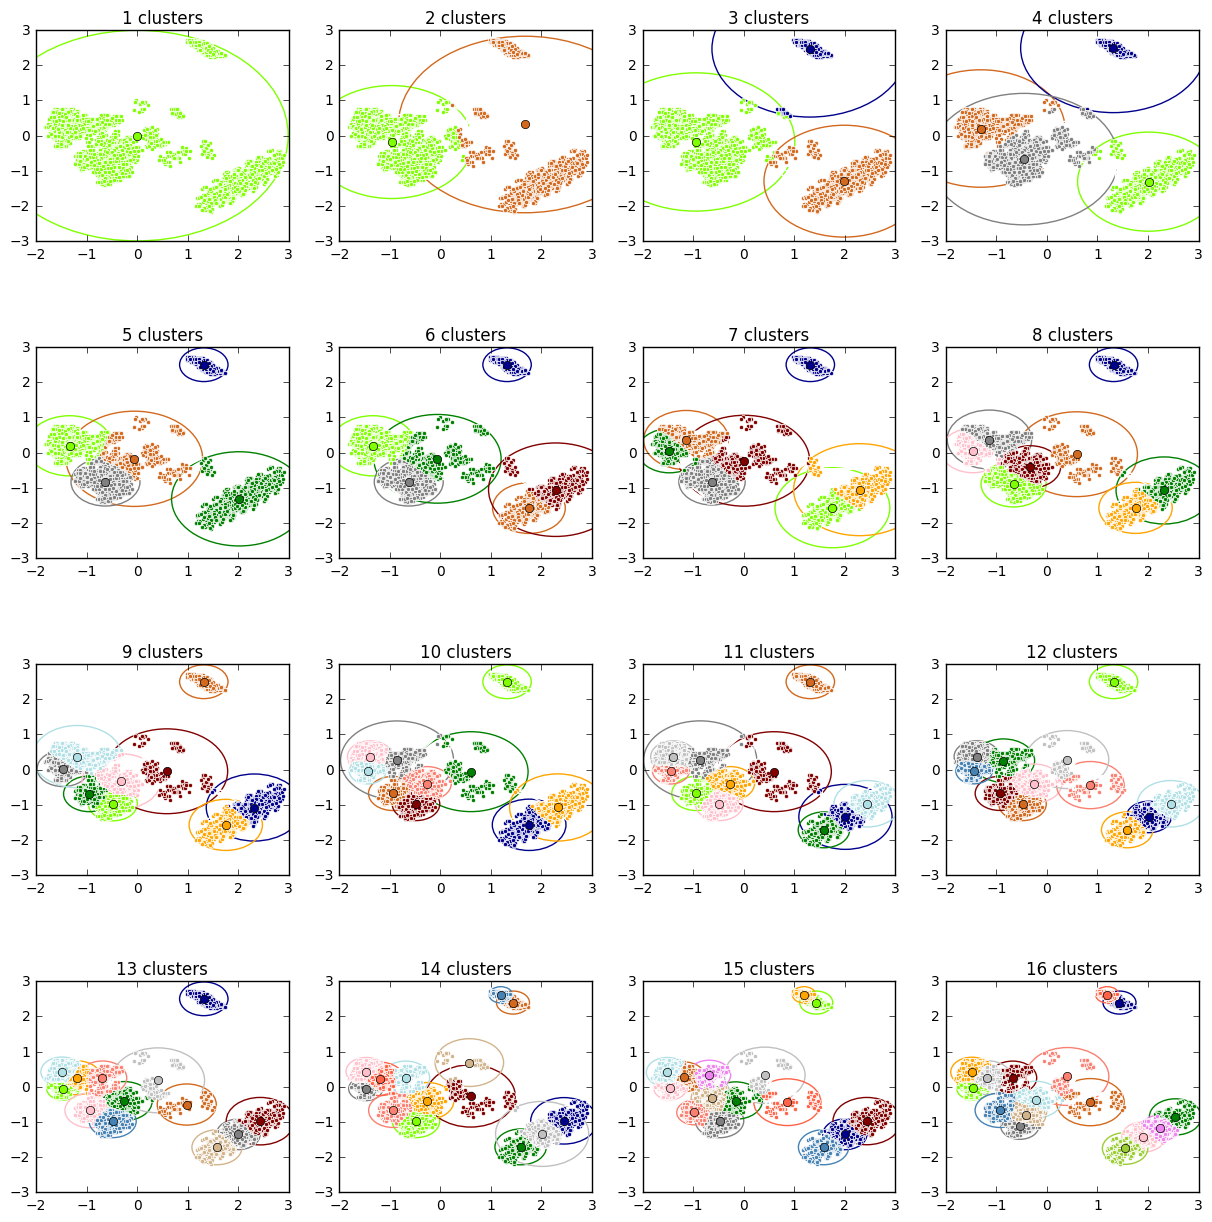

In [6]:
from scipy.spatial import distance
# References:
#    - http://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
#    - http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
#    - http://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

def max_dist(center, points):
# Greatest distance between a numpy array containing a centroid point and a numpy array of points
    ds = np.sqrt(np.sum((center-points)**2,axis=1))
    ind = np.argmax(ds)
    return ds[ind]

def P3():

    # run PCA with two dimmensions
    n_comp = 2
    pca_two = PCA(n_components = n_comp)
    X = pca_two.fit(train_data).transform(train_data)
    y = train_labels 

    # set up grid plot
    fig, axs = plt.subplots(4, 4, figsize=(15, 15)) #, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    colors=['chartreuse','chocolate','darkblue','gray', 'green', 'maroon', 'orange', 'pink', 
            'powderblue', 'salmon', 'silver', 'steelblue', 'tan', 'tomato', 'violet', 'yellowgreen']

    # calculate kmeans for 1-16 cluster sizes
    for i in range(16):
        n = i+1
        k_means = KMeans(n_clusters=n)
        k_means.fit(X) 

        for k, col in zip(range(n), colors):
            k_members = k_means.labels_ == k
            cluster_center = k_means.cluster_centers_[k]
            
            print "num clusters = %d, cluster num = %d, center = %s, population = %d" % (n, k, cluster_center, X[k_means.labels_ == k].shape[0])

            circle = plt.Circle((cluster_center[0], cluster_center[1]), max_dist(cluster_center, X[k_members,]),
                                color=col, fill=False)

            axs[i].plot(X[k_members, 0], X[k_members, 1], 'w', markerfacecolor=col, marker='.')
            axs[i].plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, 
                        markeredgecolor='k', markersize=6)
            axs[i].add_artist(circle)
            axs[i].set_title('%d clusters' % (k+1))

P3()

NOTES/OBSERVERATIONS/REFLECTIONS:
    
Plotting is always a challenge and this took far longer than it should have. I really learned to appreciate numpy arrays in this exercise.

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

In [ ]:
def P4():
# References:
#    - http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/tutorial/plot_knn_iris.html
#    - http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/

    # run PCA with two dimmensions
    pca_two = PCA(n_components = 2)
    X = pca_two.fit(train_data).transform(train_data)
    y = train_labels 
    
    # select poisonous samples 
    X_pois = X[y==1]
    #print "X_pois shape: ", X_pois.shape
    
    # set up parameter values
    components = [1, 2, 3, 4]
    covar_type = ['spherical', 'diag', 'tied', 'full']
    
    # set up grid plot
    fig, axs = plt.subplots(4, 4, figsize=(15, 15)) #, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 0.5, wspace=.2)
    axs = axs.ravel()
    
    # run the 16 different model parameter configurations
    for i, p in enumerate(product(components, covar_type)):
        print "n_comp = %d, covar = %s, plot ind = %d" % (p[0], p[1], i)
        
        # GMM using parameter option and fit to poisonous samples
        gm_pois = GaussianMixture(n_components=p[0], covariance_type=p[1])
        gm_pois.fit(X_pois)      
        
        # capture the decision boundary with h as the step size in the mesh
        h=0.02
        x_min, x_max = (X_pois[:,0].min() - .5, X_pois[:,0].max() + .5)
        y_min, y_max = (X_pois[:,1].min() - .5, X_pois[:,1].max() + .5)
        X, Y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        XX = np.array([X.ravel(), Y.ravel()]).T
        #print "XX: ", XX.shape
        
        # calculate the scores for the grid using the current GMM
        Z = -gm_pois.score_samples(XX)
        Z = Z.reshape(X.shape)
        #print "Z: ", Z.shape
        
        # plot the countours for score estimations using GMM with given parameters
        CS2 = axs[i].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                 levels=np.logspace(0, 3, 40)) 
        # plot the original data points
        axs[i].scatter(X_pois[:, 0], X_pois[:, 1], .8)
        # add the parameters in the subplot title
        axs[i].set_title('n_comp = %d, covar = %s' % (p[0], p[1]))

P4()

n_comp = 1, covar = spherical, plot ind = 0
n_comp = 1, covar = diag, plot ind = 1
n_comp = 1, covar = tied, plot ind = 2
n_comp = 1, covar = full, plot ind = 3
n_comp = 2, covar = spherical, plot ind = 4
n_comp = 2, covar = diag, plot ind = 5


/Users/jcasper/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


n_comp = 2, covar = tied, plot ind = 6
n_comp = 2, covar = full, plot ind = 7
n_comp = 3, covar = spherical, plot ind = 8
n_comp = 3, covar = diag, plot ind = 9
n_comp = 3, covar = tied, plot ind = 10
n_comp = 3, covar = full, plot ind = 11
n_comp = 4, covar = spherical, plot ind = 12
n_comp = 4, covar = diag, plot ind = 13
n_comp = 4, covar = tied, plot ind = 14
n_comp = 4, covar = full, plot ind = 15


NOTES/OBSERVATIONS/REFLECTIONS:
    
Learned way more about Numpy than planned - which was good now that I'm looking back on the process of walking through P4.

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [533]:
def P5():
# References:
#    - http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/
    
    # run PCA with two dimmensions on train_data
    pca_two = PCA(n_components = 2)
    X = pca_two.fit(train_data).transform(train_data)
    y = train_labels 
    
    # transform the test_data using the two dim PCA
    Xt = pca_two.transform(test_data)
    yt = test_labels
    
    # fit a four component full covariance GMM on the poisonous train_data and get scores for test_data
    X_pois = X[y==1]
    print "X_pois shape: ", X_pois.shape  
    gm_pois = GaussianMixture(n_components=4, covariance_type='full')
    gm_pois.fit(X_pois)
    pois_scores = gm_pois.score_samples(Xt)

    print "Score Xt: ", gm_pois.score(Xt)
    print "Score samples shape: ", pois_scores.shape
    
    # fit a four component full covariance GMM on the non-poisonous train_data
    X_nonpois = X[y==0]
    print "X_nonpois shape: ", X_nonpois.shape
    gm_nonpois = GaussianMixture(n_components=4, covariance_type='full')
    gm_nonpois.fit(X_nonpois)
    nonpois_scores = gm_nonpois.score_samples(Xt)

    print "Score Xt: ", gm_nonpois.score(Xt)
    print "Score samples: ", nonpois_scores.shape

    # calculate predication for each sample by comparing the scores from the pois and nonpois models
    predicted_labels = np.zeros(shape=yt.shape)
    for i, (pois_score, nonpois_score) in enumerate((zip(pois_scores, nonpois_scores))):
        if pois_score > nonpois_score:
            predicted_labels[i]=1
        else:
            predicted_labels[i]=0

    # output results
    print '\n-------------------------------------------'      
    print "Num matches predicted: %d/%d" % (np.sum(predicted_labels == yt), yt.shape[0])
    accuracy = float(np.sum(predicted_labels == yt))/float(yt.shape[0])
    print("Accuracy of the comparison model: %s" % ('{0:.2f}%'.format(accuracy * 100)))

P5()

X_pois shape:  (3198, 2)
Score Xt:  -1.91423120679
Score samples shape:  (1124,)
X_nonpois shape:  (3802, 2)
Score Xt:  -20.4008140533
Score samples:  (1124,)

-------------------------------------------
Num matches predicted: 1053/1124
Accuracy of the comparison model: 93.68%


NOTES/OBSERVATIONS/REFLECTIONS:

I didn't lock in the random generator so the accuracy will vary slightly but hovers between 93% and 95%. 

I enjoyed this exercise as it somehow made more sense to me overall. The one sticking point I was getting hung up on was what the score represented such that I could compare two different models' scores. After reading several different sites, I believe this makes sense.

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [534]:
def num_params(pc, gc, cov):
# calculate the number of params estimated given combo
    num_classes = 2 # pois or nonpois
    if cov == 'spherical':
        # ((num params to describe the mean vec + 1 param for sph cov) * num components) * num classes
        num_param = ((pc+1) * gc) * num_classes
    elif cov == 'diag':
        # ((num params to describe the mean vec + size of diag in cov matrix) * num components) * num classes
        num_param = ((pc+pc) * gc) * num_classes
    elif cov == 'tied':
        # ((num params to describe the mean vec * num components) + size of upper triange in cov matrix) * num classes
        num_param = ((pc*gc) + ((pc*(pc+1))/2)) * num_classes
    elif cov == 'full':
        # ((num params to describe the mean vec + size of lower triange in cov matrix) * num components) * num classes
        num_param = ((pc + ((pc*(pc+1))/2)) * gc) * num_classes
    return num_param

def P6():
# References:
#   - http://scikit-learn.org/0.15/auto_examples/mixture/plot_gmm_classifier.html
 
    # set up parameter options
    pca_comp = list(range(1,11))
    gmm_comp = list(range(1,11))
    gmm_covar = ['spherical', 'diag', 'tied', 'full']
    
    # total number of param combos
    num = list(product(pca_comp, gmm_comp, gmm_covar))
    #print len(num)
    
    train_accuracy = []
    test_accuracy = []
    accuracy_list = []
    model_params_list = []
    
    # output header
    print("index \t accuracy \t num_params \t pca_comp \t gmm_comp \t covar type\n")
    
    for i, p in enumerate(product(pca_comp, gmm_comp, gmm_covar)):
        pc, gc, cov = p[0], p[1], p[2]
        num_ps = num_params(pc, gc, cov)
        
        # try to minimize params to fit (thus limit overfitting)
        if num_ps <= 50:
            
            # run PCA with pc dimmensions on train_data
            pca_mod = PCA(n_components = pc)
            X = pca_mod.fit(train_data).transform(train_data)
            y = train_labels 
    
            # transform the test_data using the pc dim PCA
            Xt = pca_mod.transform(test_data)
            yt = test_labels  
            
            # fit a GMM on the reduced poisonous train_data and get scores for test_data
            X_pois = X[y==1]
            gmm_pois = GaussianMixture(n_components=gc, covariance_type=cov)
            gmm_pois.fit(X_pois)
            pois_scores = gmm_pois.score_samples(Xt)
    
            # fit a GMM on the reduced non-poisonous train_data and get scores for test_data
            X_nonpois = X[y==0]
            gmm_nonpois = GaussianMixture(n_components=gc, covariance_type=cov)
            gmm_nonpois.fit(X_nonpois)
            nonpois_scores = gmm_nonpois.score_samples(Xt)
            
            # calculate prediction by comparing the scores from the pois and nonpois models
            predicted_labels = np.zeros(shape=yt.shape)
            for j, (pois_score, nonpois_score) in enumerate((zip(pois_scores, nonpois_scores))):
                if pois_score > nonpois_score:
                    predicted_labels[j]=1
                else:
                    predicted_labels[j]=0
                    
            accuracy = float(np.sum(predicted_labels == yt))/float(yt.shape[0])
            
            accuracy_list.append(accuracy)
            model_params_list.append(p)
            
            # output params and accuracy
            print("%d \t %s \t %d \t\t %d \t\t %d \t\t %s" % 
                 (i, '{0:.2f}%'.format(accuracy * 100), num_ps, pc, gc, cov))
            pc, gc, cov
    
    max_acc = max(accuracy_list)
    max_index = accuracy_list.index(max_acc)

    # output best accuracy achieved
    print '\n-------------------------------------------' 
    print("Best model accuracy using %d pca_comp, %d gm_comp, and %s covar_type: %s" % 
          (model_params_list[max_index][0], model_params_list[max_index][1], model_params_list[max_index][2],
           '{0:.2f}%'.format(max_acc * 100)))    

P6()

index 	 accuracy 	 num_params 	 pca_comp 	 gmm_comp 	 covar type

0 	 84.43% 	 4 		 1 		 1 		 spherical
1 	 84.43% 	 4 		 1 		 1 		 diag
2 	 84.43% 	 4 		 1 		 1 		 tied
3 	 84.43% 	 4 		 1 		 1 		 full
4 	 89.86% 	 8 		 1 		 2 		 spherical
5 	 89.86% 	 8 		 1 		 2 		 diag
6 	 88.35% 	 6 		 1 		 2 		 tied
7 	 89.86% 	 8 		 1 		 2 		 full
8 	 90.84% 	 12 		 1 		 3 		 spherical
9 	 90.93% 	 12 		 1 		 3 		 diag
10 	 91.55% 	 8 		 1 		 3 		 tied
11 	 90.93% 	 12 		 1 		 3 		 full
12 	 91.64% 	 16 		 1 		 4 		 spherical
13 	 91.64% 	 16 		 1 		 4 		 diag
14 	 91.81% 	 10 		 1 		 4 		 tied
15 	 91.28% 	 16 		 1 		 4 		 full
16 	 91.37% 	 20 		 1 		 5 		 spherical
17 	 91.28% 	 20 		 1 		 5 		 diag
18 	 91.19% 	 12 		 1 		 5 		 tied
19 	 91.10% 	 20 		 1 		 5 		 full
20 	 90.93% 	 24 		 1 		 6 		 spherical
21 	 90.75% 	 24 		 1 		 6 		 diag
22 	 91.28% 	 14 		 1 		 6 		 tied
23 	 91.37% 	 24 		 1 		 6 		 full
24 	 91.37% 	 28 		 1 		 7 		 spherical
25 	 91.37% 	 28 		 1 		 7 		 diag
26 	 91.

NOTES/OBSERVATIONS/REFLECTIONS:

This was probably my favorite problem for this assignment. It brought a lot of concepts together for me. I cannot guarantee I'm calculating the parameter estimation correctly. However, the calculations are what I managed to internalize from the sync session, async, and readings. 

I made use of the comparative GMM model approach to calculate accuracy. It made the most sense to me. Is there a different way to calculate GMM accuracy? I found reference to a different way, but didn't have the time to understand useage. 

I could have coded things much cleaner. However, I left it verbose in order for me to track internal steps especially when bouncing between problems and my mind doesn't checkpoint the way it used to.

This assignment took me about 100 hours. This is a rough estimate as I've been picking away at it since it came out. And when I was coding, I was reading or thinking about it. On average, I would estimate 80 hours per homework. This may be excessive, but my strengths don't lie in statistics or machine learning thus it takes me additional effort to attempt to internalize concepts such that I may hope to retain and explain to others.